In [1]:
import os
import string
import folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# KIKmix_20230701.csv 분석

In [3]:
KIKmix_df = pd.read_csv('../../data/KIKmix_20230701.csv')

KIKmix_df['행정동코드'] = KIKmix_df['행정동코드'].astype(str)
KIKmix_df['법정동코드'] = KIKmix_df['법정동코드'].astype(str)

print(KIKmix_df.head())

print("--------------------")
print("00으로 끝나지 않는 행정동코드")
for i in range(len(KIKmix_df)):
    row = KIKmix_df.iloc[i]
    if not row['행정동코드'].endswith('00'):
        print(row['행정동코드'])

        행정동코드    시도명 시군구명   읍면동명       법정동코드    동리명      생성일자  말소일자
0  1100000000  서울특별시  NaN    NaN  1100000000  서울특별시  19880423   NaN
1  1111000000  서울특별시  종로구    NaN  1111000000    종로구  19880423   NaN
2  1111051500  서울특별시  종로구  청운효자동  1111010100    청운동  20081101   NaN
3  1111051500  서울특별시  종로구  청운효자동  1111010200    신교동  20081101   NaN
4  1111051500  서울특별시  종로구  청운효자동  1111010300    궁정동  20081101   NaN
--------------------
00으로 끝나지 않는 행정동코드


# KIKmix_20230701.csv 분석 결과
1. 행정동코드는 총 10자리로 구성
2. 행정동코드는 2자리(시도코드) + 3자리(시군구코드) + 5자리(음면동코드)로 구성
   1. 행정동코드 중 마지막 2자리는 의미 없는듯 함 (모든 값이 00으로 끝남)
3. 행정동 주소는 시도명, 시군구명, 읍면동명으로 구성
4. 법정동코드는 총 10자리로 구성


# EDA
- 기간
  - 행사 기간 - 2023년 09월 02일 ~ 2023년 09월 10일
  - 비교 기간 - 2023년 09월 16일 ~ 2023년 09월 24일
- 장소
  - 무주군 무주읍
  - 행정동코드 - 4573025000
- 방문 목적
   - 0: 귀가
   - 1: 업무
   - 2: 학업
   - 3: 쇼핑여가
   - 4: 기타
   - 5: 여행
   - 중 분석 대상은 '쇼핑여가' + '기타' + '여행'으로 함

## EDA Strategy
1. 데이터 불러오기
  - 불러오는 도중에 데이터 필터링 및 전처리
### OD data EDA Strategy
1. 지도에 OD 데이터 시각화
   1. `무주읍`이 도착지인 데이터 시각화 *파란색으로 표시*
   2. `무주읍`이 출발지인 데이터 시각화 *빨간색으로 표시*
2. 시간 관련 데이터 EDA
   1. 날짜 분포 확인
      <!-- 1. 출발지 기준 날짜 분포 확인 - 도착지가 무주읍 -->
      2. 도착지 기준 날짜 분포 확인 - 출발지가 무주읍
   <!-- 2. 출발 시각, 도착 시각 분포 확인
      1. 출발지 기준 출발 시각, 도착 인각 분포 확인 - 도착지가 무주읍
      2. 도착지 기준 도착 시각, 출발 시각 분포 확읍 - 출발지가 무주읍 -->
   3. 평균 이동시간 분포 확인
      1. 출발지 기준 평균 이동시간 분포 확인 - 도착지가 무주읍
      2. 도착지 기준 평균 이동시간 분포 확인 - 출발지가 무주읍
3. 이동 관련 데이터 EDA
   1. 평균 이동거리 분포 확인
      <!-- 1. 출발지 기준 평균 이동거리 분포 확인 - 도착지가 무주읍 -->
      2. 도착지 기준 평균 이동거리 분포 확인 - 출발지가 무주읍
   2. 주 이동수단 분포 확인
      <!-- 1. 출발지 기준 주 이동수단 분포 확인 - 도착지가 무주읍 -->
      2. 도착지 기준 주 이동수단 분포 확인 - 출발지가 무주읍
   3. 이동 인원 분포 확인
      1. 출발지 기준 이동 인원 분포 확인 - 도착지가 무주읍
      2. 도착지 기준 이동 인원 분포 확인 - 출발지가 무주읍
4. 사람 관련 데이터 EDA
   1. 성별과 연령대 분포 확인

### Stay data EDA Strategy
1. 시간대에 따른 분포 확인
2. 성별과 연령대 분포 확인
3. 체류 인원 분포 확인

In [4]:
root = '../../data'
listdir = os.listdir(root)
dirs = [f for f in listdir if os.path.isdir(f'{root}/{f}')]

if f'od_df_filtered.csv' in listdir and f'stay_df_filtered.csv' in listdir:
    od_df = pd.read_csv(f'{root}/od_df_filtered.csv')
    stay_df = pd.read_csv(f'{root}/stay_df_filtered.csv')

else:
    dirs_in_period = [
        'od_20230901_10',
        'od_20230911_20',
        'od_20230921_30',
        'stay_20230901_15',
        'stay_20230916_30'
    ]

    files_in_period = ['od_202309{:02d}_1'.format(i) for i in range(16, 25)] +\
    ['od_202309{:02d}_1'.format(i) for i in range(2, 11)] +\
    ['stay_202309{:02d}_1'.format(i) for i in range(2, 11)] +\
    ['stay_202309{:02d}_1'.format(i) for i in range(16, 25)]

    print(files_in_period)

    od_dirs = [f for f in dirs_in_period if 'od' in f.lower() and 'zip' not in f.lower()]
    od_files = [os.listdir(f'{root}/{f}') for f in od_dirs]

    od_dfs = []
    for i in tqdm(range(len(od_dirs))):
        for j in range(len(od_files[i])):
            
            if od_files[i][j].replace('.csv', '') not in files_in_period:
                continue
            
            df = pd.read_csv(
                f'{root}/{od_dirs[i]}/{od_files[i][j]}',
                dtype={
                    # 'origin_hdong_cd': pd.UInt32Dtype(),
                    # 'dest_hdong_cd': pd.UInt32Dtype(),
                    # 'date': pd.UInt32Dtype(),
                    # 'gender': pd.UInt8Dtype(),
                    # 'age': pd.UInt8Dtype(),
                    # 'modal': pd.UInt8Dtype(),
                    # 'origin_purpose': pd.UInt8Dtype(),
                    # 'dest_purpose': pd.UInt8Dtype(),
                    # 'od_dist_avg': pd.UInt16Dtype(),
                    # 'od_duration_avg': pd.UInt8Dtype(),
                    # 'od_cnts': pd.UInt8Dtype(),
                }
            )
            df = df.dropna()
            df = df.drop_duplicates()
            # 날짜 & 출발지 & 도착지 & 방문 목적 기준 필터링
            df = df[
                ((df['origin_purpose'] == 3) | (df['origin_purpose'] == 4) | (df['origin_purpose'] == 5))
            ]
            df = df[
                ((df['dest_purpose'] == 0) | (df['dest_purpose'] == 3) | (df['dest_purpose'] == 4) | (df['dest_purpose'] == 5))
            ]
            df = df[
                ((df['origin_hdong_cd'] == 4573025000) | (df['dest_hdong_cd'] == 4573025000))
            ]
            df = df[
                (df['origin_hdong_cd'] != df['dest_hdong_cd'])
            ]

            od_dfs.append(df)
        

    od_df = pd.concat(od_dfs)

    stay_dirs = [f for f in dirs_in_period if 'stay' in f.lower() and 'zip' not in f.lower()]
    stay_files = [os.listdir(f'{root}/{f}') for f in stay_dirs]

    stay_dfs = []
    for i in tqdm(range(len(stay_dirs))):
        for j in range(len(stay_files[i])):
            
            if stay_files[i][j].replace('.csv', '') not in files_in_period:
                continue
            
            df = pd.read_csv(
                f'{root}/{stay_dirs[i]}/{stay_files[i][j]}',
                dtype={
                    # 'gender': pd.UInt8Dtype(),
                    # 'age': pd.UInt8Dtype(),
                    # 'purpose': pd.UInt8Dtype(),
                    # 'stay_cnts': pd.UInt16Dtype(),
                }
            )
            df = df.dropna()
            df = df.drop_duplicates()
            # 체류 장소 & 날짜 & 방문 목적 기준 필터링
            df = df[
                (df['hdong_cd'] == 4573025000)
            ]
            df = df[
                ((df['purpose'] == 3) | (df['purpose'] == 4) | (df['purpose'] == 5))
            ]

            stay_dfs.append(df)

    stay_df = pd.concat(stay_dfs)

print(od_df.info())
print(od_df.head())
print(od_df.shape)

print(stay_df.info())
print(stay_df.head())
print(stay_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   origin_hdong_cd  7165 non-null   int64  
 1   dest_hdong_cd    7165 non-null   int64  
 2   date             7165 non-null   int64  
 3   start_time       7165 non-null   object 
 4   end_time         7165 non-null   object 
 5   gender           7165 non-null   int64  
 6   age              7165 non-null   int64  
 7   modal            7165 non-null   float64
 8   origin_purpose   7165 non-null   float64
 9   dest_purpose     7165 non-null   int64  
 10  od_dist_avg      7165 non-null   int64  
 11  od_duration_avg  7165 non-null   int64  
 12  od_cnts          7165 non-null   int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 727.8+ KB
None
   origin_hdong_cd  dest_hdong_cd      date start_time end_time  gender  age  \
0       4573033000     4573025000  20230902      20:00

##### Save filtered data

In [5]:
od_df.to_csv(f'{root}/od_df_filtered.csv', index=False)
stay_df.to_csv(f'{root}/stay_df_filtered.csv', index=False)

# Analysis of OD data

# OD data EDA Strategy

## 지도에 OD 데이터 시각화

In [6]:
def cd_to_addr(cd: str, addr_cord_mapper: pd.DataFrame) -> tuple[str, float, float]:
    '''
    행정동 코드를 입력받아 해당 행정동의 주소와 위도, 경도를 반환
    :param cd: 행정동 코드
    :return
        - 주소: str
        - 위도: float
        - 경도: float
    '''
    df = addr_cord_mapper.copy()

    df['행정동코드'] = df['행정동코드'].astype(str)
    res = df[df['행정동코드'] == cd].copy()

    res[['시도명', '시군구명', '읍면동명']] = res[['시도명', '시군구명', '읍면동명']].fillna('')
    
    try:
        addr = " ".join(res[['시도명', '시군구명', '읍면동명']].values[0])
        lat = res['위도'].values[0]
        long = res['경도'].values[0]
    except Exception as e:
        print(f'Error: {e}')
        print(f'행정동 코드 {cd}에 대한 정보를 찾을 수 없습니다.')
        print(res[['시도명', '시군구명', '읍면동명']].values)
        print(res)
    
    return addr, lat, long

In [7]:
def harvesine(lat1, lon1, lat2, lon2):
    '''
    두 지점의 위도, 경도를 입력받아 대원거리를 계산
    :param lat1: 지점1 위도
    :param lon1: 지점1 경도
    :param lat2: 지점2 위도
    :param lon2: 지점2 경도
    :return: 대원거리 (m)
    '''
    R = 6371000
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1

    a = np.sin(delta_lat / 2) * np.sin(delta_lat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) * np.sin(delta_lon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [8]:
muju_eup_cord = (36.002621, 127.661528)

near_threshold_radius = 1000

addr_cord_mapper = pd.read_csv('../../../address_with_lon_lat_final.csv')

modal_to_modal_name = {
    0: '차량',
    1: '시내버스',
    2: '지하철',
    3: '도보',
    4: '기타',
    5: '철도',
    6: '시외고속버스',
    7: '항공기',
}

In [9]:
def draw_parkinglots(folium_map):

    parking_lots = pd.read_csv(f'{root}/전북특별자치도_무주군_주차장정보_20240429.csv', encoding='cp949')

    print(f'무주군 내 주차장 수: {len(parking_lots)}')
    print(f'무주군 내 총 주차구획수: {parking_lots['주차구획수'].sum()}')

    near_parking_lots = parking_lots[
        parking_lots.apply(
            lambda x: harvesine(x['위도'], x['경도'], muju_eup_cord[0], muju_eup_cord[1]) <= near_threshold_radius, axis=1
        )
    ]

    print(f'행사장 반경 {near_threshold_radius}m 이내 주차장 수: {len(near_parking_lots)}')
    print(f'행사장 반경 {near_threshold_radius}m 이내 총 주차구획수: {near_parking_lots["주차구획수"].sum()}')

    for i in range(len(near_parking_lots)):
        row = near_parking_lots.iloc[i]
        folium.Marker(
            location=[row['위도'], row['경도']],
            popup=f"{row['주차장명']} ({row['주차구획수']}대)",
            icon=folium.Icon(color='green')
        ).add_to(folium_map)

    folium.Circle(
        muju_eup_cord,
        radius=near_threshold_radius,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.2,
        popup='행사장',
    ).add_to(folium_map)

    return folium_map


## 도착지가 무주읍인 데이터 시각화

In [10]:
folium_map = folium.Map(location=muju_eup_cord, zoom_start=15)

folium_map = draw_parkinglots(folium_map)

od_df_visit = od_df.copy()
od_df_visit = od_df_visit[od_df_visit['dest_hdong_cd'] == 4573025000]
od_df_visit = od_df_visit[od_df_visit['dest_purpose'] != 0]

od_df_visit['origin_city_code'] = od_df_visit['origin_hdong_cd'].astype(str).str[:2]
origin_city_ratio = od_df_visit['origin_city_code'].value_counts(normalize=True)

for i in range(len(origin_city_ratio)):
    row = origin_city_ratio.iloc[i]

    city_hdong_cd = origin_city_ratio.index[i]
    city_hdong_cd = str(city_hdong_cd) + "00000000"
    
    addr, lat, long = cd_to_addr(city_hdong_cd, addr_cord_mapper)
    
    opacity = origin_city_ratio.loc[city_hdong_cd[:2]]
    
    folium.Marker(
        location=[lat, long],
        # popup=f"{addr} ({row['od_cnts']}명)",
        icon=folium.Icon(color='blue')
    ).add_to(folium_map)

    folium.PolyLine(
        locations=[[lat, long], muju_eup_cord],
        color='blue',
        weight=10,
        opacity=opacity
    ).add_to(folium_map)

folium_map
# folium_map.save('folium_map_visit.html')
origin_city_ratio

무주군 내 주차장 수: 19
무주군 내 총 주차구획수: 1019
행사장 반경 1000m 이내 주차장 수: 19
행사장 반경 1000m 이내 총 주차구획수: 1019


origin_city_code
45    0.809524
43    0.044266
30    0.041583
44    0.036217
47    0.018779
48    0.015426
29    0.006036
27    0.006036
41    0.004695
11    0.004695
36    0.004024
46    0.004024
26    0.003353
51    0.001341
Name: proportion, dtype: float64

## 출발지가 무주읍인 데이터 시각화

In [11]:
folium_map = folium.Map(location=muju_eup_cord, zoom_start=15)

folium_map = draw_parkinglots(folium_map)

od_df_leave = od_df.copy()
od_df_leave = od_df_leave[od_df_leave['origin_hdong_cd'] == 4573025000]
od_df_leave = od_df_leave[od_df_leave['origin_purpose'] == 0] # 귀가

od_df_leave['dest_city_code'] = od_df_leave['dest_hdong_cd'].astype(str).str[:2]

dest_city_ratio = od_df_leave['dest_city_code'].value_counts(normalize=True)

for i in range(len(dest_city_ratio)):
    row = dest_city_ratio.iloc[i]

    city_hdong_cd = dest_city_ratio.index[i]
    city_hdong_cd = str(city_hdong_cd) + "00000000"
    
    addr, lat, long = cd_to_addr(city_hdong_cd, addr_cord_mapper)
    
    opacity = dest_city_ratio.loc[city_hdong_cd[:2]]
    
    folium.Marker(
        location=[lat, long],
        # popup=f"{addr} ({row['od_cnts']}명)",
        icon=folium.Icon(color='blue')
    ).add_to(folium_map)

    folium.PolyLine(
        locations=[[lat, long], muju_eup_cord],
        color='red',
        weight=10,
        opacity=opacity
    ).add_to(folium_map)
    
folium_map.save('folium_map_leave.html')

무주군 내 주차장 수: 19
무주군 내 총 주차구획수: 1019
행사장 반경 1000m 이내 주차장 수: 19
행사장 반경 1000m 이내 총 주차구획수: 1019


# 시간 관련 데이터 EDA

In [12]:
in_period_dt_range = pd.date_range(start='2023-09-02', end='2023-09-10')
not_in_period_dt_range = pd.date_range(start='2023-09-16', end='2023-09-24')

In [13]:
def get_leave_df() -> pd.DataFrame:
    od_df_leave = od_df.copy()
    od_df_leave = od_df_leave[od_df_leave['origin_hdong_cd'] == 4573025000]
    od_df_leave = od_df_leave[od_df_leave['dest_purpose'] == 0]
    
    # od_df_leave['date']를 datetime으로 변환
    od_df_leave['date'] = pd.to_datetime(od_df_leave['date'], format='%Y%m%d')

    return od_df_leave

## 1. 날짜 분포 확인

### 축제 기간 중 집계된 행사장에서 다른 지역으로 귀가한 인원

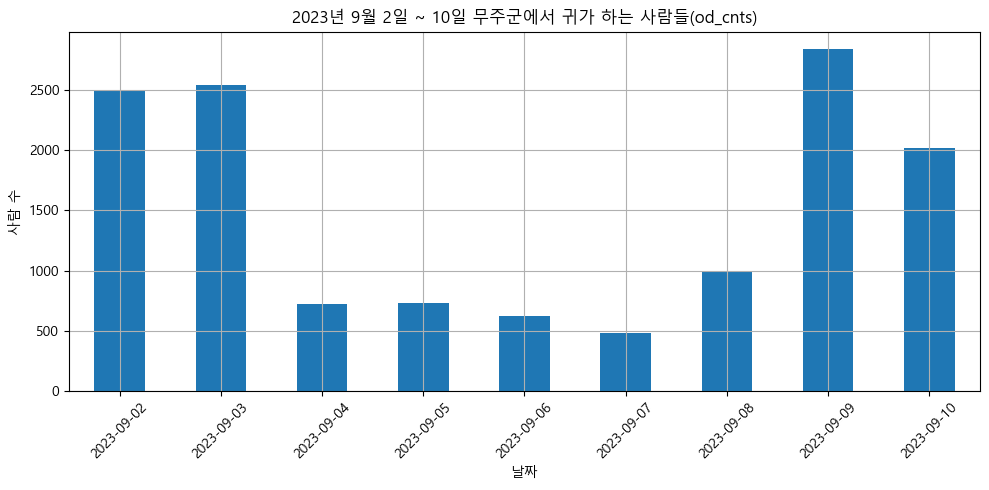

In [14]:
od_df_leave = get_leave_df()

leave_in_period_df = od_df_leave[
    od_df_leave['date'].isin(in_period_dt_range)
]

leave_not_in_period_od_duration_cnt = {}
for date in in_period_dt_range:
    date = date.strftime('%Y-%m-%d')
    leave_not_in_period_od_duration_cnt[date] = leave_in_period_df[leave_in_period_df['date'] == date]['od_cnts'].sum()
    
leave_not_in_period_od_duration_cnt = pd.Series(leave_not_in_period_od_duration_cnt)

plt.figure(figsize=(10, 5))
leave_not_in_period_od_duration_cnt.plot(kind='bar')
plt.title('2023년 9월 2일 ~ 10일 무주군에서 귀가 하는 사람들(od_cnts)')
plt.xlabel('날짜')
plt.ylabel('사람 수')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### 축제 기간 이외 집계된 행사장에서 다른 지역으로 귀가한 인원

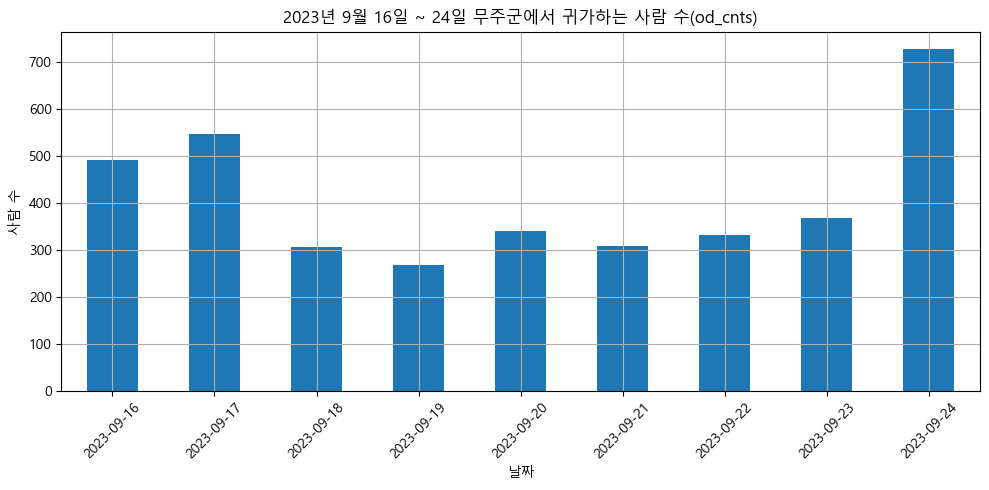

In [15]:
od_df_leave = get_leave_df()

leave_not_in_period_df = od_df_leave[
    od_df_leave['date'].isin(not_in_period_dt_range)
]

leave_not_in_period_od_duration_cnt = {}
for date in not_in_period_dt_range:
    date = date.strftime('%Y-%m-%d')
    leave_not_in_period_od_duration_cnt[date] = leave_not_in_period_df[leave_not_in_period_df['date'] == date]['od_cnts'].sum()
    
leave_not_in_period_od_duration_cnt = pd.Series(leave_not_in_period_od_duration_cnt)

plt.figure(figsize=(10, 5))
leave_not_in_period_od_duration_cnt.plot(kind='bar')
plt.title('2023년 9월 16일 ~ 24일 무주군에서 귀가하는 사람 수(od_cnts)')
plt.xlabel('날짜')
plt.ylabel('사람 수')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

## 위 두개 합친거

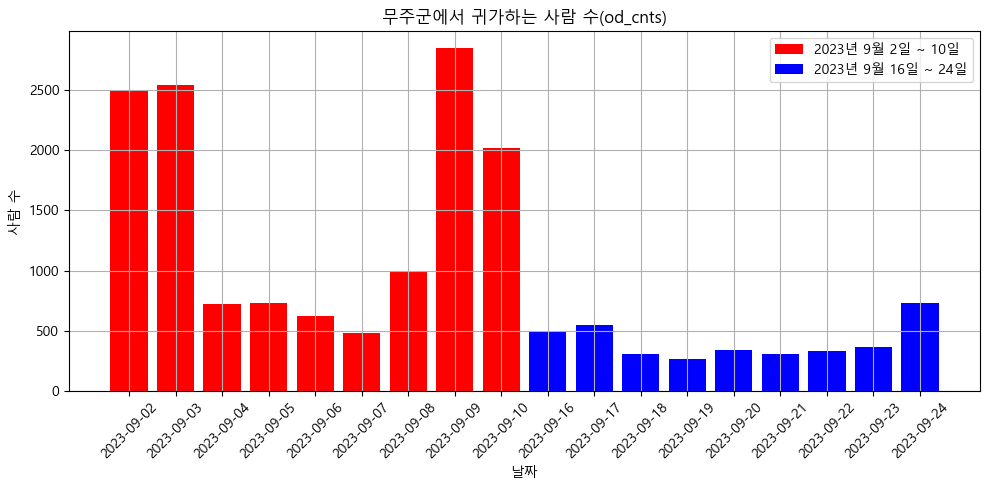

In [32]:
od_df_leave = get_leave_df()

leave_in_period_df = od_df_leave[
    od_df_leave['date'].isin(in_period_dt_range)
]
leave_not_in_period_df = od_df_leave[
    od_df_leave['date'].isin(not_in_period_dt_range)
]

leave_in_period_od_duration_cnt = {}
for date in in_period_dt_range:
    date = date.strftime('%Y-%m-%d')
    leave_in_period_od_duration_cnt[date] = leave_in_period_df[leave_in_period_df['date'] == date]['od_cnts'].sum()

leave_not_in_period_od_duration_cnt = {}
for date in not_in_period_dt_range:
    date = date.strftime('%Y-%m-%d')
    leave_not_in_period_od_duration_cnt[date] = leave_not_in_period_df[leave_not_in_period_df['date'] == date]['od_cnts'].sum()
    
leave_in_period_od_duration_cnt = pd.Series(leave_in_period_od_duration_cnt)
leave_not_in_period_od_duration_cnt = pd.Series(leave_not_in_period_od_duration_cnt)

plt.figure(figsize=(10, 5))

plt.bar(leave_in_period_od_duration_cnt.index, leave_in_period_od_duration_cnt, label='2023년 9월 2일 ~ 10일', color='red')
plt.bar(leave_not_in_period_od_duration_cnt.index, leave_not_in_period_od_duration_cnt, label='2023년 9월 16일 ~ 24일', color='blue')

plt.title('무주군에서 귀가하는 사람 수(od_cnts)')
plt.xlabel('날짜')
plt.ylabel('사람 수')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


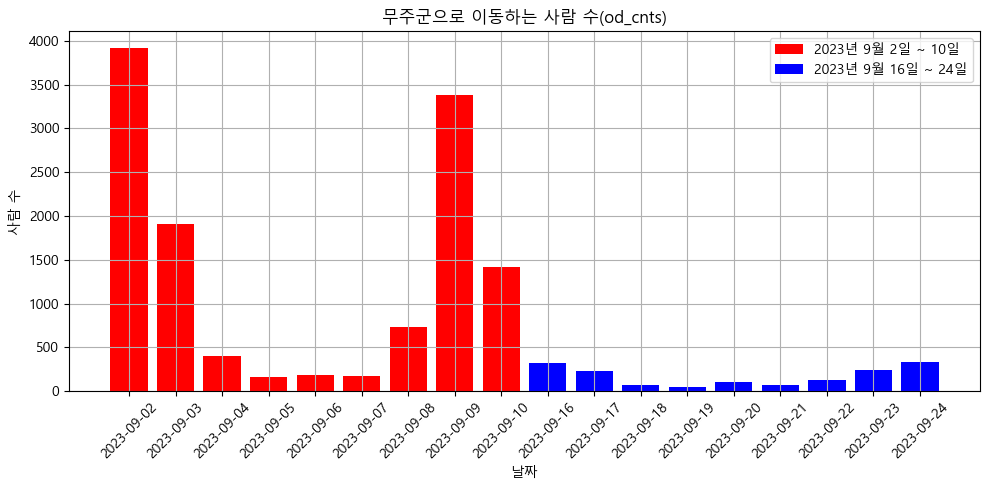

In [33]:
od_df_visit['date'] = pd.to_datetime(od_df_visit['date'], format='%Y%m%d')

visit_in_period_df = od_df_visit[
    od_df_visit['date'].isin(in_period_dt_range)
]
visit_not_in_period_df = od_df_visit[
    od_df_visit['date'].isin(not_in_period_dt_range)
]

visit_in_period_od_duration_cnt = {}
for date in in_period_dt_range:
    date = date.strftime('%Y-%m-%d')
    visit_in_period_od_duration_cnt[date] = visit_in_period_df[visit_in_period_df['date'] == date]['od_cnts'].sum()

visit_not_in_period_od_duration_cnt = {}
for date in not_in_period_dt_range:
    date = date.strftime('%Y-%m-%d')
    visit_not_in_period_od_duration_cnt[date] = visit_not_in_period_df[visit_not_in_period_df['date'] == date]['od_cnts'].sum()
    
visit_in_period_od_duration_cnt = pd.Series(visit_in_period_od_duration_cnt)
visit_not_in_period_od_duration_cnt = pd.Series(visit_not_in_period_od_duration_cnt)

plt.figure(figsize=(10, 5))

plt.bar(visit_in_period_od_duration_cnt.index, visit_in_period_od_duration_cnt, label='2023년 9월 2일 ~ 10일', color='red')
plt.bar(visit_not_in_period_od_duration_cnt.index, visit_not_in_period_od_duration_cnt, label='2023년 9월 16일 ~ 24일', color='blue')

plt.title('무주군으로 이동하는 사람 수(od_cnts)')
plt.xlabel('날짜')
plt.ylabel('사람 수')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


## 3. 일 별 평균 이동시간 분포 확인
- 출발지 기준 평균 이동시간 분포 확인 - 도착지가 무주읍
- 도착지 기준 평균 이동시간 분포 확인 - 출발지가 무주읍

### 축제 기간과 아닌 기간에 무주군을 떠나는 사람들의 출발 시간 분포 비교

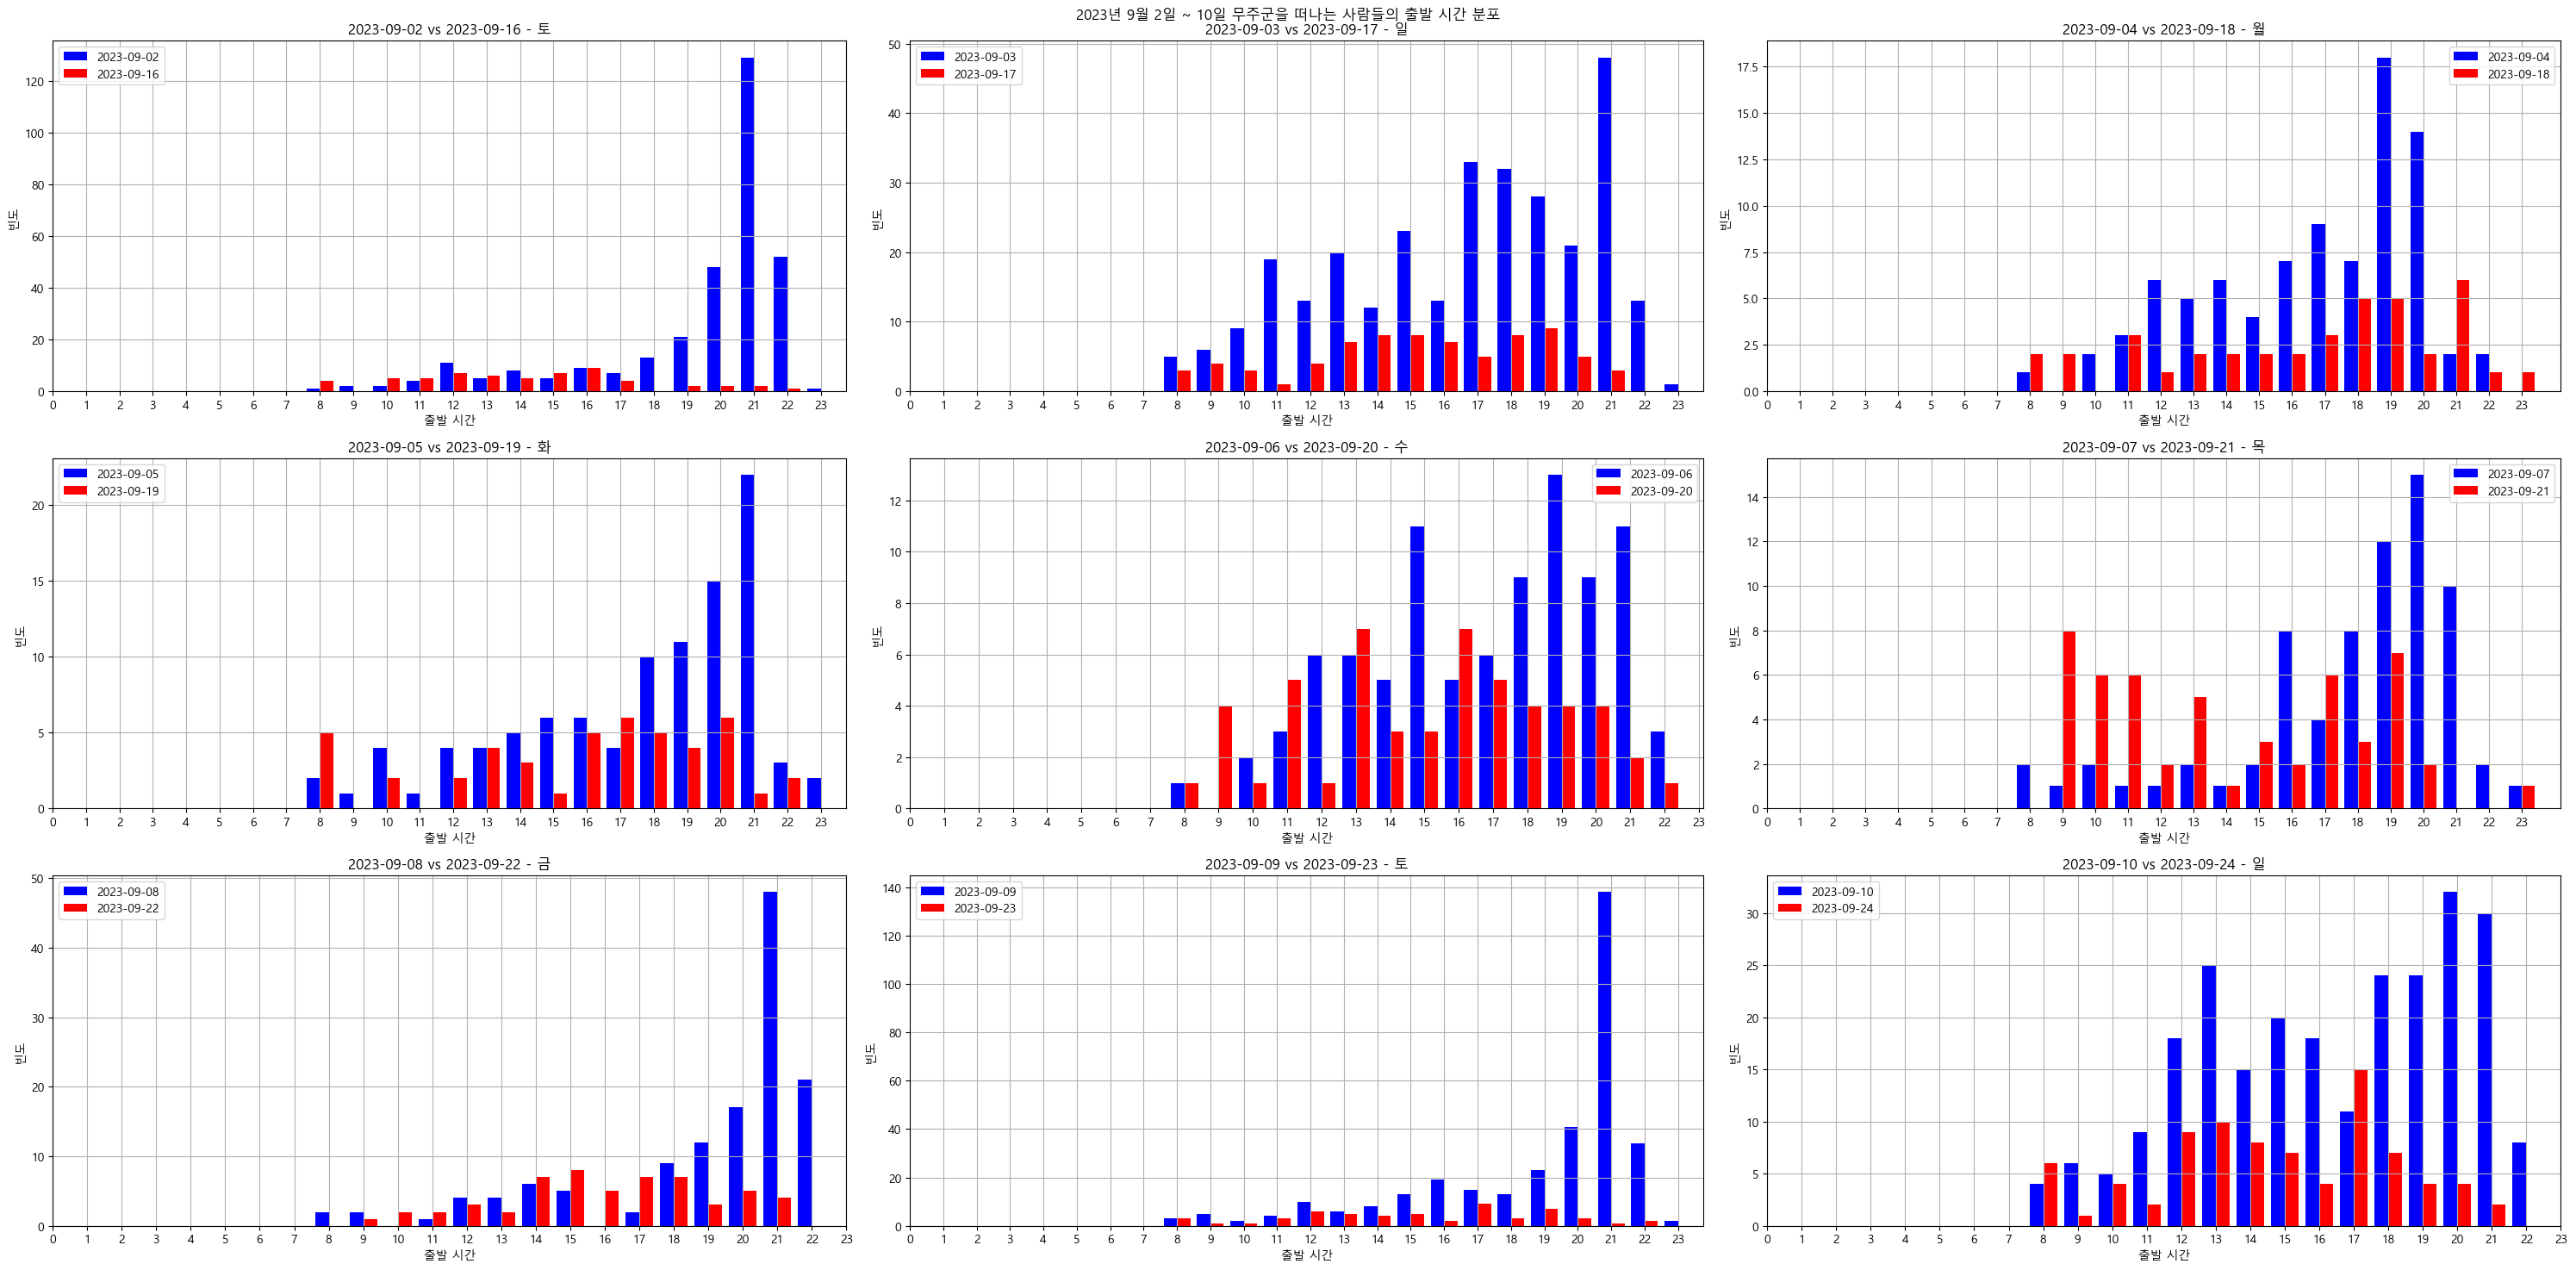

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(30, 15))

fig.suptitle('2023년 9월 2일 ~ 10일 무주군을 떠나는 사람들의 출발 시간 분포')

weekday_ = ['월', '화', '수', '목', '금', '토', '일']

od_df_leave = od_df.copy()
od_df_leave = od_df_leave[od_df_leave['origin_hdong_cd'] == 4573025000]
od_df_leave = od_df_leave[od_df_leave['dest_purpose'] == 0]
od_df_leave['date'] = pd.to_datetime(od_df_leave['date'], format='%Y%m%d')

for i in range(3):
    for j in range(3):
        in_period_date = in_period_dt_range[i*3+j]
        week_day = in_period_date.weekday()
        in_period_date = in_period_date.strftime('%Y-%m-%d')


        not_in_period_date = not_in_period_dt_range[i*3+j]
        not_in_period_date = not_in_period_date.strftime('%Y-%m-%d')

        leave_not_in_period_od_duration_cnt = od_df_leave[od_df_leave['date'] == in_period_date]['start_time']
        leave_not_in_period_od_duration_avg = od_df_leave[od_df_leave['date'] == not_in_period_date]['start_time']

        leave_not_in_period_od_duration_cnt = leave_not_in_period_od_duration_cnt.value_counts().sort_index()
        leave_not_in_period_od_duration_avg = leave_not_in_period_od_duration_avg.value_counts().sort_index()

        leave_not_in_period_od_duration_cnt.index = leave_not_in_period_od_duration_cnt.index.str.split(':').str[0].astype(int)
        leave_not_in_period_od_duration_avg.index = leave_not_in_period_od_duration_avg.index.str.split(':').str[0].astype(int)

        axs[i][j].bar(
            leave_not_in_period_od_duration_cnt.index - 0.2,
            leave_not_in_period_od_duration_cnt.values,
            color='r', label=f'{in_period_date}', width=0.4
        )
        axs[i][j].bar(
            leave_not_in_period_od_duration_avg.index + 0.2,
            leave_not_in_period_od_duration_avg.values,
            color='b', label=f'{not_in_period_date}', width=0.4
        )
        
        axs[i][j].set_title(f'{in_period_date} vs {not_in_period_date} - {weekday_[week_day]}')
        axs[i][j].set_xlabel('출발 시간')
        axs[i][j].set_ylabel('빈도')
        axs[i][j].set_xticks(range(24))
        axs[i][j].legend()
        axs[i][j].grid()
        
plt.tight_layout()
plt.show()

### 축제 기간과 아닌 기간에 무주군을 떠나는 사람들의 출발 시간 분포 비교

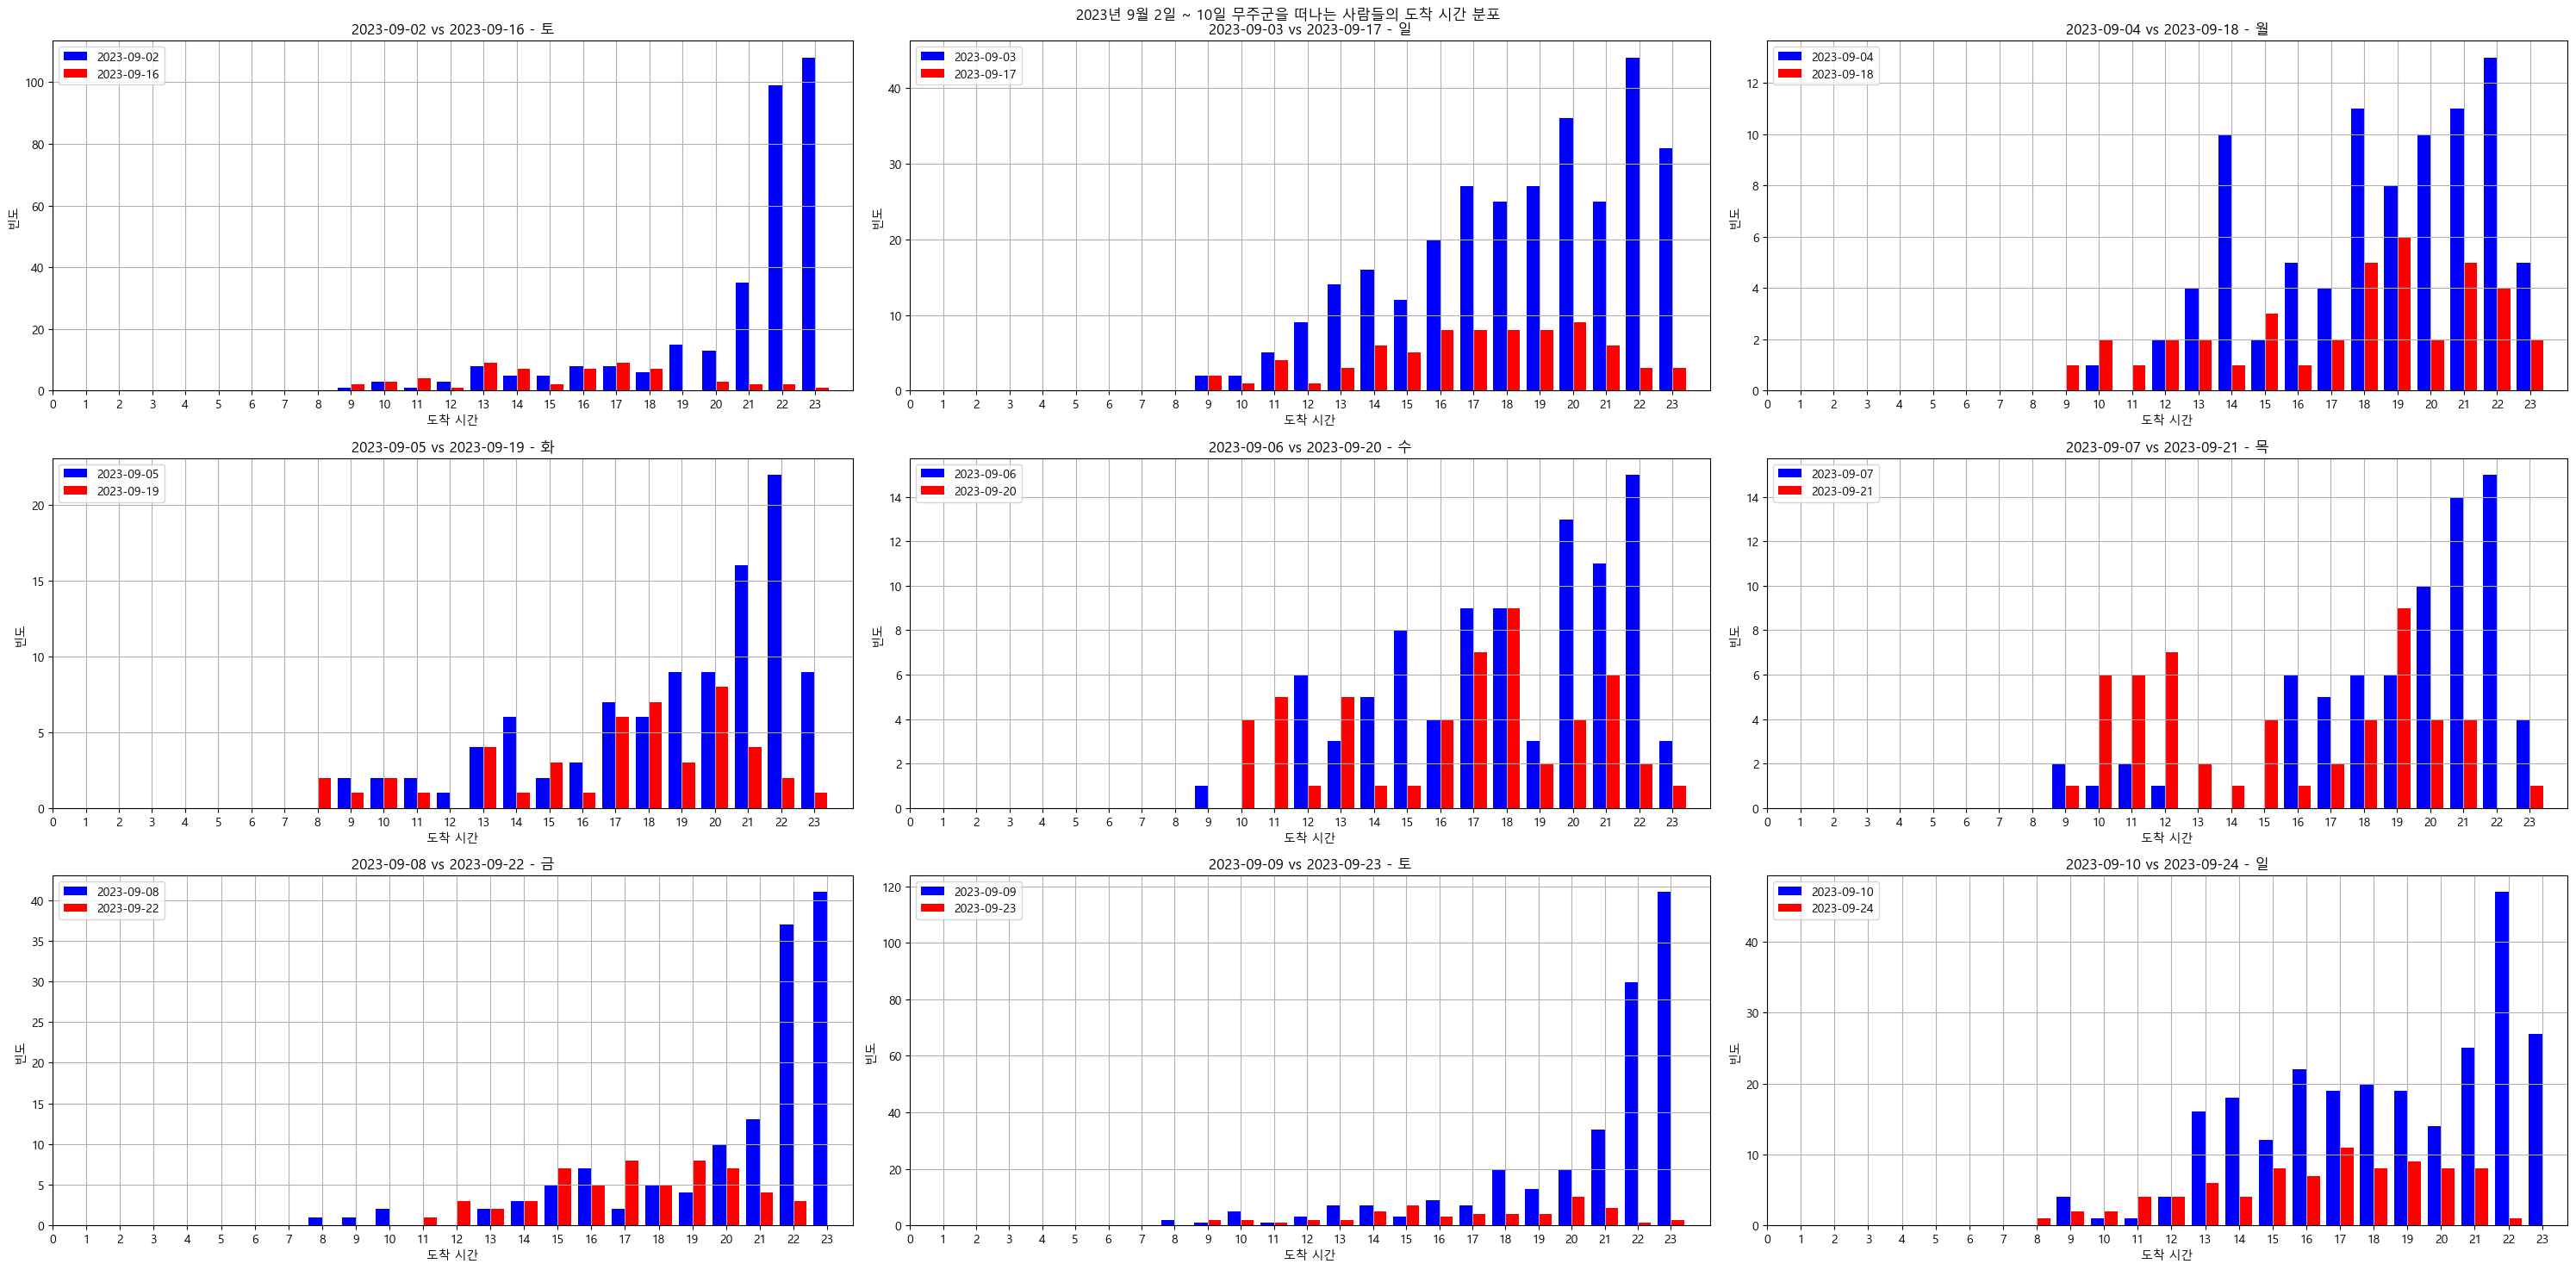

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(30, 15))

fig.suptitle('2023년 9월 2일 ~ 10일 무주군을 떠나는 사람들의 도착 시간 분포')

weekday_ = ['월', '화', '수', '목', '금', '토', '일']

od_df_leave = od_df.copy()
od_df_leave = od_df_leave[od_df_leave['origin_hdong_cd'] == 4573025000]
od_df_leave = od_df_leave[od_df_leave['dest_purpose'] == 0]
od_df_leave['date'] = pd.to_datetime(od_df_leave['date'], format='%Y%m%d')

for i in range(3):
    for j in range(3):
        in_period_date = in_period_dt_range[i*3+j]
        week_day = in_period_date.weekday()
        in_period_date = in_period_date.strftime('%Y-%m-%d')


        not_in_period_date = not_in_period_dt_range[i*3+j]
        not_in_period_date = not_in_period_date.strftime('%Y-%m-%d')

        leave_not_in_period_od_duration_cnt = od_df_leave[od_df_leave['date'] == in_period_date]['end_time']
        leave_not_in_period_od_duration_avg = od_df_leave[od_df_leave['date'] == not_in_period_date]['end_time']

        leave_not_in_period_od_duration_cnt = leave_not_in_period_od_duration_cnt.value_counts().sort_index()
        leave_not_in_period_od_duration_avg = leave_not_in_period_od_duration_avg.value_counts().sort_index()

        leave_not_in_period_od_duration_cnt.index = leave_not_in_period_od_duration_cnt.index.str.split(':').str[0].astype(int)
        leave_not_in_period_od_duration_avg.index = leave_not_in_period_od_duration_avg.index.str.split(':').str[0].astype(int)

        axs[i][j].bar(
            leave_not_in_period_od_duration_cnt.index - 0.2,
            leave_not_in_period_od_duration_cnt.values,
            color='b', label=f'{in_period_date}', width=0.4
        )
        axs[i][j].bar(
            leave_not_in_period_od_duration_avg.index + 0.2,
            leave_not_in_period_od_duration_avg.values,
            color='r', label=f'{not_in_period_date}', width=0.4
        )
        
        axs[i][j].set_title(f'{in_period_date} vs {not_in_period_date} - {weekday_[week_day]}')
        axs[i][j].set_xlabel('도착 시간')
        axs[i][j].set_ylabel('빈도')
        axs[i][j].set_xticks(range(24))
        axs[i][j].legend()
        axs[i][j].grid()
        
plt.tight_layout()
plt.show()

### 축제 기간 중 집계된 행사장을 떠나는 사람들이 이동하는데 걸린 시간 분포

C:\Users\min99\AppData\Local\Temp\ipykernel_43644\22477616.py:14: FutureWarning: Starting with pandas version 3.0 all arguments of to_clipboard will be keyword-only.
  od_df_leave_grouped_by_dest.to_clipboard(True)


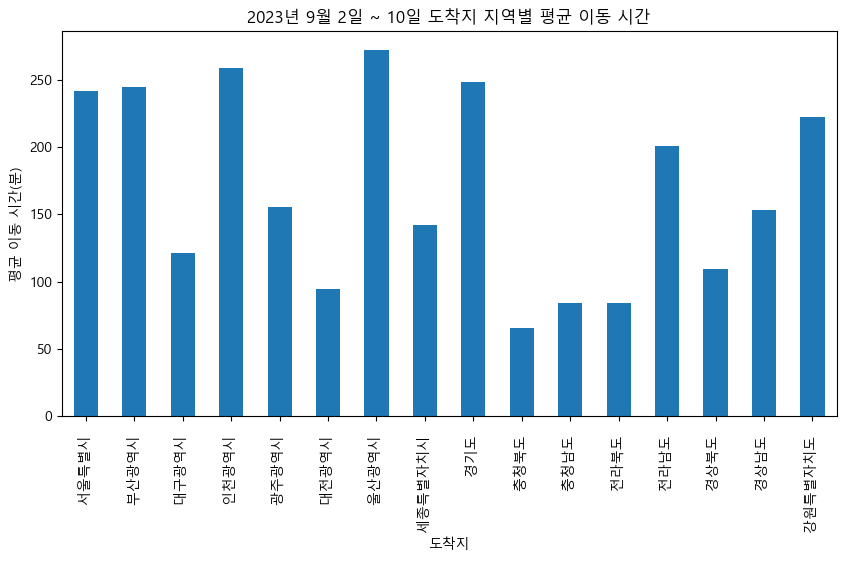

In [18]:
# 도착지 지역별로 그룹화한 뒤 각 지역별 이동하는데 평균적으로 걸린 시간 분포
od_df_leave['dest_city_code'] = od_df_leave['dest_hdong_cd'].astype(str).str[:2]
od_df_leave_in_period = od_df_leave[od_df_leave['date'].isin(in_period_dt_range)]

od_df_leave_grouped_by_dest = od_df_leave_in_period.groupby('dest_city_code')['od_duration_avg'].mean()
od_df_leave_grouped_by_dest.index = od_df_leave_grouped_by_dest.index.to_series().apply(lambda x: str(x) + "00000000")
od_df_leave_grouped_by_dest.index = od_df_leave_grouped_by_dest.index.to_series().apply(lambda x: cd_to_addr(str(x), addr_cord_mapper)[0])

od_df_leave_grouped_by_dest.plot(
  kind='bar', figsize=(10, 5),
  xlabel='도착지', ylabel='평균 이동 시간(분)',
  title='2023년 9월 2일 ~ 10일 도착지 지역별 평균 이동 시간'
)
od_df_leave_grouped_by_dest.to_clipboard(True)

### 축제 기간 이외 집계된 행사장을 떠나는 사람들이 이동하는데 걸린 시간 분포

C:\Users\min99\AppData\Local\Temp\ipykernel_43644\3389112351.py:14: FutureWarning: Starting with pandas version 3.0 all arguments of to_clipboard will be keyword-only.
  od_df_leave_grouped_by_dest.to_clipboard(True)


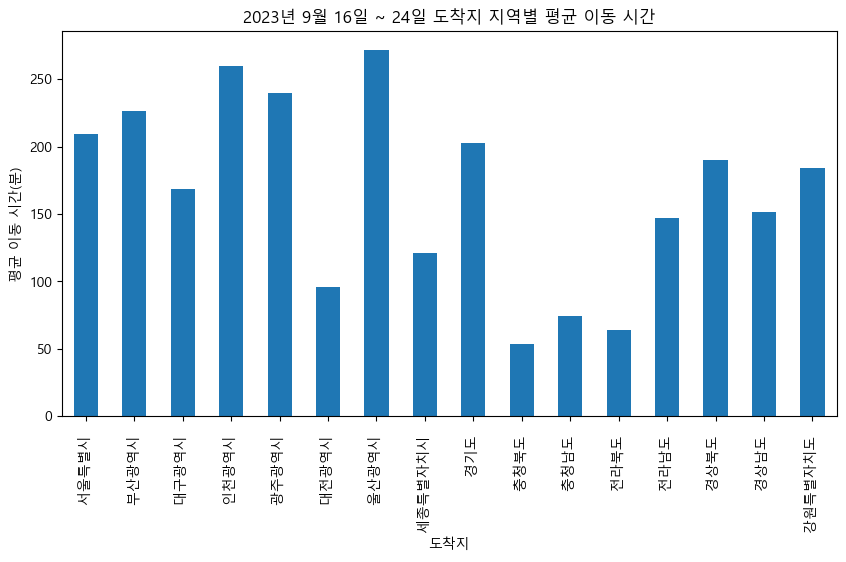

In [19]:
# 도착지 지역별로 그룹화한 뒤 각 지역별 이동하는데 평균적으로 걸린 시간 분포
od_df_leave['dest_city_code'] = od_df_leave['dest_hdong_cd'].astype(str).str[:2]
od_df_leave_not_in_period = od_df_leave[od_df_leave['date'].isin(not_in_period_dt_range)]

od_df_leave_grouped_by_dest = od_df_leave_not_in_period.groupby('dest_city_code')['od_duration_avg'].mean()
od_df_leave_grouped_by_dest.index = od_df_leave_grouped_by_dest.index.to_series().apply(lambda x: str(x) + "00000000")
od_df_leave_grouped_by_dest.index = od_df_leave_grouped_by_dest.index.to_series().apply(lambda x: cd_to_addr(str(x), addr_cord_mapper)[0])

od_df_leave_grouped_by_dest.plot(
  kind='bar', figsize=(10, 5),
  xlabel='도착지', ylabel='평균 이동 시간(분)',
  title='2023년 9월 16일 ~ 24일 도착지 지역별 평균 이동 시간'
)
od_df_leave_grouped_by_dest.to_clipboard(True)

### 지역별 귀가하는데 걸린 시간 분포
- 위 두개 합친거임

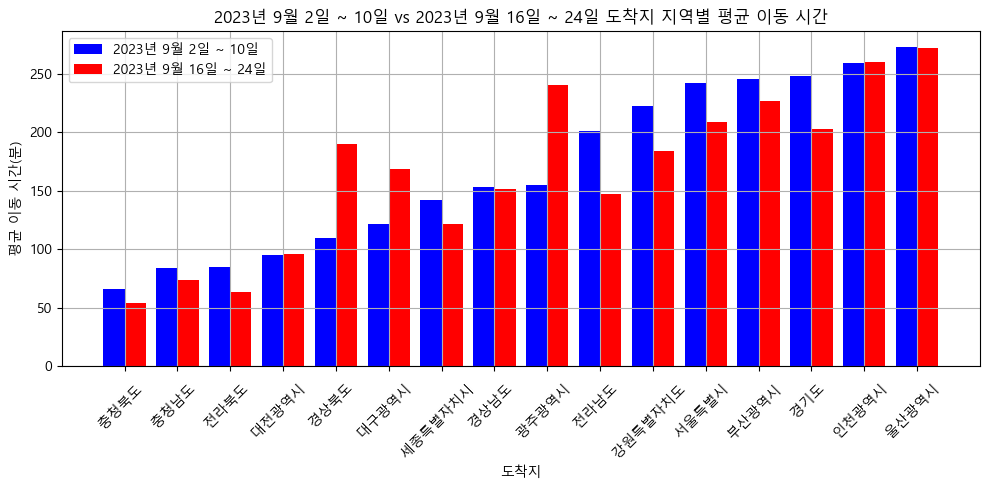

In [20]:
od_df_leave = get_leave_df()

od_df_leave['dest_city_code'] = od_df_leave['dest_hdong_cd'].astype(str).str[:2]

od_df_leave_in_period = od_df_leave[od_df_leave['date'].isin(in_period_dt_range)]
od_df_leave_not_in_period = od_df_leave[od_df_leave['date'].isin(not_in_period_dt_range)]

od_df_leave_grouped_by_dest_in_period = od_df_leave_in_period.groupby('dest_city_code')['od_duration_avg'].mean()
od_df_leave_grouped_by_dest_not_in_period = od_df_leave_not_in_period.groupby('dest_city_code')['od_duration_avg'].mean()

od_df_leave_grouped_by_dest_in_period = od_df_leave_grouped_by_dest_in_period.to_frame()
od_df_leave_grouped_by_dest_not_in_period = od_df_leave_grouped_by_dest_not_in_period.to_frame()

od_df_leave_grouped_by_dest_in_period = od_df_leave_grouped_by_dest_in_period.rename(columns={'od_duration_avg': '2023년 9월 2일 ~ 10일'})
od_df_leave_grouped_by_dest_not_in_period = od_df_leave_grouped_by_dest_not_in_period.rename(columns={'od_duration_avg': '2023년 9월 16일 ~ 24일'})

od_df_leave_grouped_by_dest_both = pd.concat([od_df_leave_grouped_by_dest_in_period, od_df_leave_grouped_by_dest_not_in_period], axis=1)

od_df_leave_grouped_by_dest_both.sort_values(by='2023년 9월 2일 ~ 10일', inplace=True)

od_df_leave_grouped_by_dest_both['city_name'] = od_df_leave_grouped_by_dest_both.index.to_series().apply(lambda x: str(x) + "00000000")
od_df_leave_grouped_by_dest_both['city_name'] = od_df_leave_grouped_by_dest_both['city_name'].apply(lambda x: cd_to_addr(str(x), addr_cord_mapper)[0])

plt.figure(figsize=(10, 5))

plt.bar(
    np.arange(len(od_df_leave_grouped_by_dest_both)) - 0.2,
    od_df_leave_grouped_by_dest_both['2023년 9월 2일 ~ 10일'].values,
    color='b', label='2023년 9월 2일 ~ 10일', width=0.4    
)
plt.bar(
    np.arange(len(od_df_leave_grouped_by_dest_both)) + 0.2,
    od_df_leave_grouped_by_dest_both['2023년 9월 16일 ~ 24일'].values,
    color='r', label='2023년 9월 16일 ~ 24일', width=0.4
)

plt.xticks(range(len(od_df_leave_grouped_by_dest_both)), od_df_leave_grouped_by_dest_both['city_name'], rotation=45)
plt.xlabel('도착지')
plt.ylabel('평균 이동 시간(분)')
plt.title('2023년 9월 2일 ~ 10일 vs 2023년 9월 16일 ~ 24일 도착지 지역별 평균 이동 시간')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### 지역별 귀가하는데 이동한 거리 분포

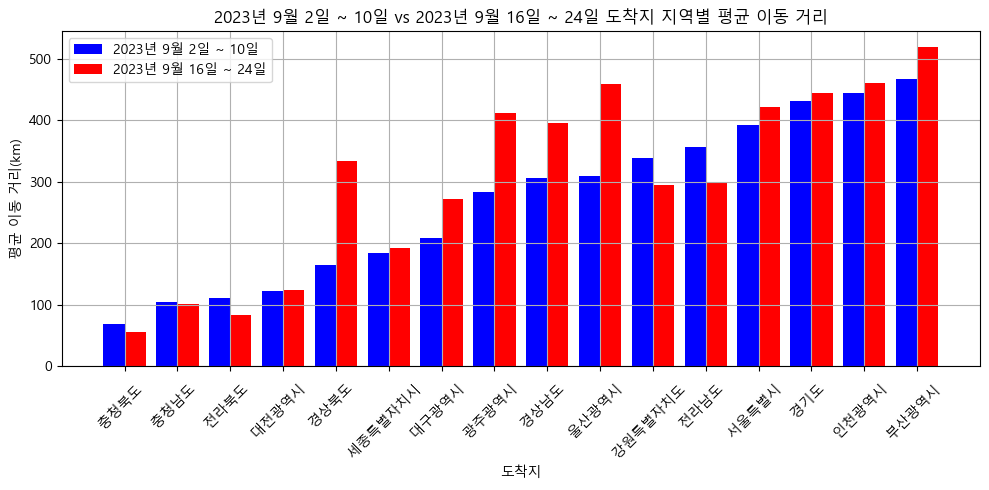

In [21]:
od_df_leave = get_leave_df()

od_df_leave['dest_city_code'] = od_df_leave['dest_hdong_cd'].astype(str).str[:2]

od_df_leave_in_period = od_df_leave[od_df_leave['date'].isin(in_period_dt_range)]
od_df_leave_not_in_period = od_df_leave[od_df_leave['date'].isin(not_in_period_dt_range)]

od_df_leave_grouped_by_dest_in_period = od_df_leave_in_period.groupby('dest_city_code')['od_dist_avg'].mean()
od_df_leave_grouped_by_dest_not_in_period = od_df_leave_not_in_period.groupby('dest_city_code')['od_dist_avg'].mean()

od_df_leave_grouped_by_dest_in_period = od_df_leave_grouped_by_dest_in_period.to_frame()
od_df_leave_grouped_by_dest_not_in_period = od_df_leave_grouped_by_dest_not_in_period.to_frame()

od_df_leave_grouped_by_dest_in_period = od_df_leave_grouped_by_dest_in_period.rename(columns={'od_dist_avg': '2023년 9월 2일 ~ 10일'})
od_df_leave_grouped_by_dest_not_in_period = od_df_leave_grouped_by_dest_not_in_period.rename(columns={'od_dist_avg': '2023년 9월 16일 ~ 24일'})

od_df_leave_grouped_by_dest_both = pd.concat([od_df_leave_grouped_by_dest_in_period, od_df_leave_grouped_by_dest_not_in_period], axis=1)

od_df_leave_grouped_by_dest_both.sort_values(by='2023년 9월 2일 ~ 10일', inplace=True)
od_df_leave_grouped_by_dest_both = od_df_leave_grouped_by_dest_both.apply(lambda x: x / 1000)

od_df_leave_grouped_by_dest_both['city_name'] = od_df_leave_grouped_by_dest_both.index.to_series().apply(lambda x: str(x) + "00000000")
od_df_leave_grouped_by_dest_both['city_name'] = od_df_leave_grouped_by_dest_both['city_name'].apply(lambda x: cd_to_addr(str(x), addr_cord_mapper)[0])

plt.figure(figsize=(10, 5))

plt.bar(
    np.arange(len(od_df_leave_grouped_by_dest_both)) - 0.2,
    od_df_leave_grouped_by_dest_both['2023년 9월 2일 ~ 10일'].values,
    color='b', label='2023년 9월 2일 ~ 10일', width=0.4    
)
plt.bar(
    np.arange(len(od_df_leave_grouped_by_dest_both)) + 0.2,
    od_df_leave_grouped_by_dest_both['2023년 9월 16일 ~ 24일'].values,
    color='r', label='2023년 9월 16일 ~ 24일', width=0.4
)

plt.xticks(range(len(od_df_leave_grouped_by_dest_both)), od_df_leave_grouped_by_dest_both['city_name'], rotation=45)
plt.xlabel('도착지')
plt.ylabel('평균 이동 거리(km)')
plt.title('2023년 9월 2일 ~ 10일 vs 2023년 9월 16일 ~ 24일 도착지 지역별 평균 이동 거리')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 행사장을 떠나는 사람들이 이용한 주 이동수단

### 축제 기간 중 행사장을 떠나는 사람들이 이용한 주 이동수단

C:\Users\min99\AppData\Local\Temp\ipykernel_43644\1184340800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_df_leave_in_period['modal_name'] = od_df_leave_in_period['modal'].map(modal_to_modal_name)


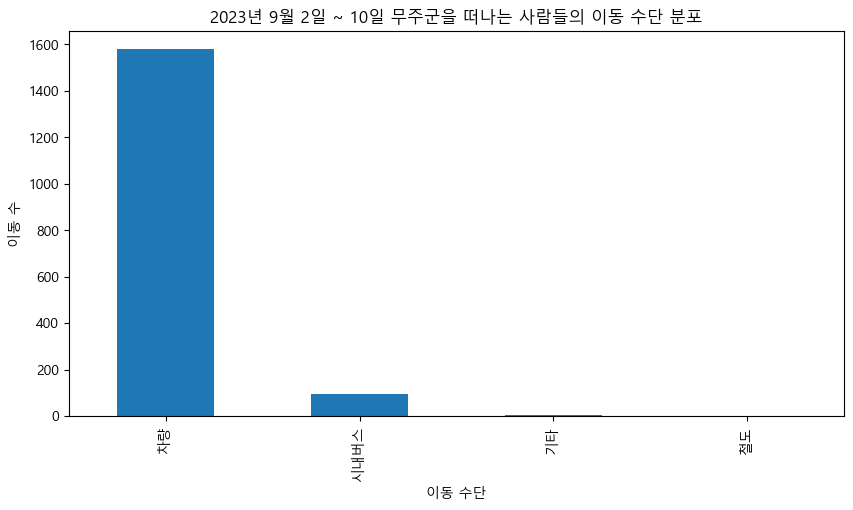

modal_name
차량      1579
시내버스      94
기타         6
철도         1
Name: count, dtype: int64

In [22]:
od_df_leave_in_period = od_df_leave[od_df_leave['date'].isin(in_period_dt_range)]
od_df_leave_in_period['modal_name'] = od_df_leave_in_period['modal'].map(modal_to_modal_name)

od_df_leave_in_period['modal_name'].value_counts().plot(
    kind='bar', figsize=(10, 5),
    xlabel='이동 수단', ylabel='이동 수',
    title='2023년 9월 2일 ~ 10일 무주군을 떠나는 사람들의 이동 수단 분포'
)
plt.show()
od_df_leave_in_period['modal_name'].value_counts()

### 축제 기간 이외 행사장을 떠나는 사람들이 이용한 주 이동수단

C:\Users\min99\AppData\Local\Temp\ipykernel_43644\3542909157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_df_leave_not_in_period['modal_name'] = od_df_leave_not_in_period['modal'].map(modal_to_modal_name)


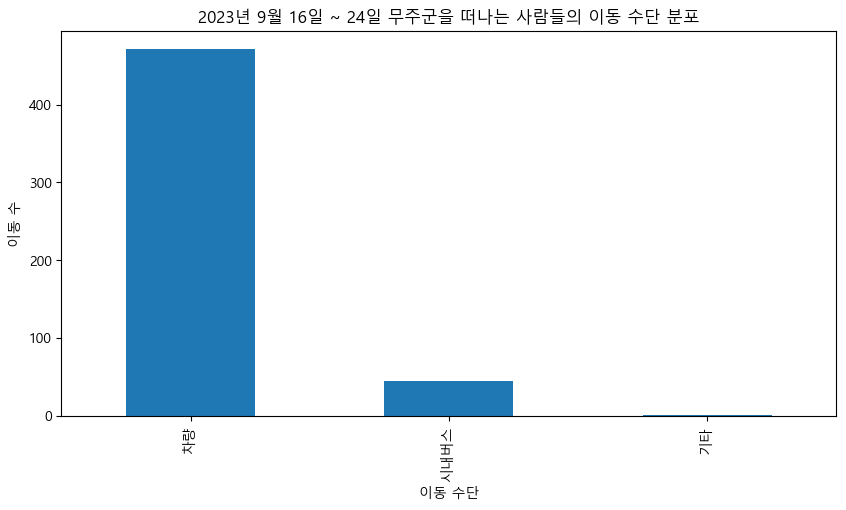

modal_name
차량      471
시내버스     45
기타        1
Name: count, dtype: int64

In [23]:
od_df_leave_not_in_period = od_df_leave[od_df_leave['date'].isin(not_in_period_dt_range)]
od_df_leave_not_in_period['modal_name'] = od_df_leave_not_in_period['modal'].map(modal_to_modal_name)

od_df_leave_not_in_period['modal_name'].value_counts().plot(
    kind='bar', figsize=(10, 5),
    xlabel='이동 수단', ylabel='이동 수',
    title='2023년 9월 16일 ~ 24일 무주군을 떠나는 사람들의 이동 수단 분포'
)
plt.show()
od_df_leave_not_in_period['modal_name'].value_counts()

이 이후로는 두개 이상의 변수 상관관계 조사
ex. 각 도착지 지역별 이동 수단 분포

## 무주군에서 귀가한 사람들이 도착한 지역과 각 지역별 od_cnts

C:\Users\min99\AppData\Local\Temp\ipykernel_43644\3149282181.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_df_leave_in_period['city_name'] = od_df_leave_in_period['dest_hdong_cd'].astype(str).str[:2]
C:\Users\min99\AppData\Local\Temp\ipykernel_43644\3149282181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_df_leave_not_in_period['city_name'] = od_df_leave_not_in_period['dest_hdong_cd'].astype(str).str[:2]


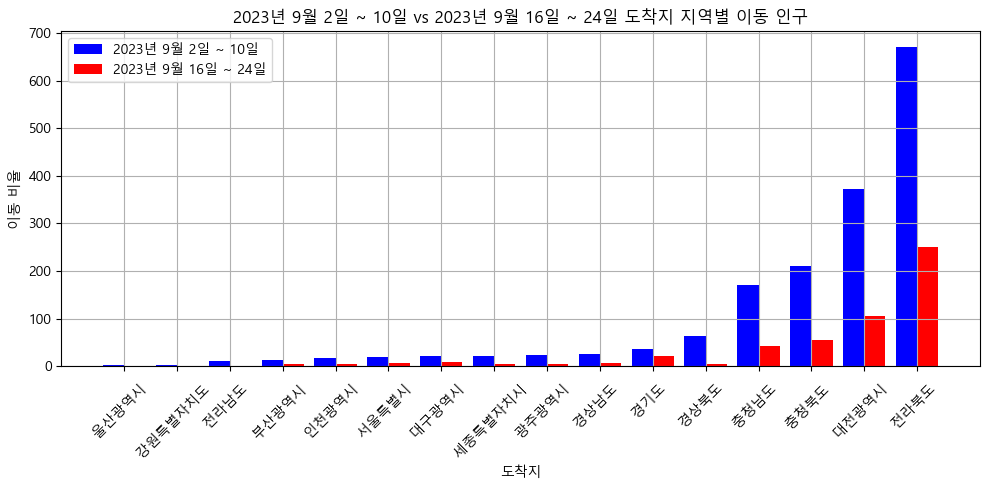

In [24]:
od_df_leave = get_leave_df()

od_df_leave_in_period = od_df_leave[od_df_leave['date'].isin(in_period_dt_range)]
od_df_leave_not_in_period = od_df_leave[od_df_leave['date'].isin(not_in_period_dt_range)]

od_df_leave_in_period['city_name'] = od_df_leave_in_period['dest_hdong_cd'].astype(str).str[:2]
od_df_leave_not_in_period['city_name'] = od_df_leave_not_in_period['dest_hdong_cd'].astype(str).str[:2]

od_df_leave_in_period_grouped_by_city = od_df_leave_in_period.groupby('city_name')['od_cnts'].count()
od_df_leave_not_in_period_grouped_by_city = od_df_leave_not_in_period.groupby('city_name')['od_cnts'].count()

od_df_leave_in_period_grouped_by_city = od_df_leave_in_period_grouped_by_city.to_frame()
od_df_leave_not_in_period_grouped_by_city = od_df_leave_not_in_period_grouped_by_city.to_frame()

od_df_leave_in_period_grouped_by_city = od_df_leave_in_period_grouped_by_city.rename(columns={'od_cnts': '2023년 9월 2일 ~ 10일'})
od_df_leave_not_in_period_grouped_by_city = od_df_leave_not_in_period_grouped_by_city.rename(columns={'od_cnts': '2023년 9월 16일 ~ 24일'})

od_df_leave_grouped_by_city_both = pd.concat([od_df_leave_in_period_grouped_by_city, od_df_leave_not_in_period_grouped_by_city], axis=1)

od_df_leave_grouped_by_city_both.sort_values(by='2023년 9월 2일 ~ 10일', inplace=True)

od_df_leave_grouped_by_city_both['city_name'] = od_df_leave_grouped_by_city_both.index.to_series().apply(lambda x: str(x) + "00000000")
od_df_leave_grouped_by_city_both['city_name'] = od_df_leave_grouped_by_city_both['city_name'].apply(lambda x: cd_to_addr(str(x), addr_cord_mapper)[0])

plt.figure(figsize=(10, 5))

plt.bar(
    np.arange(len(od_df_leave_grouped_by_city_both)) - 0.2,
    od_df_leave_grouped_by_city_both['2023년 9월 2일 ~ 10일'].values,
    color='b', label='2023년 9월 2일 ~ 10일', width=0.4    
)
plt.bar(
    np.arange(len(od_df_leave_grouped_by_city_both)) + 0.2,
    od_df_leave_grouped_by_city_both['2023년 9월 16일 ~ 24일'].values,
    color='r', label='2023년 9월 16일 ~ 24일', width=0.4
)

plt.xticks(range(len(od_df_leave_grouped_by_city_both)), od_df_leave_grouped_by_city_both['city_name'], rotation=45)
plt.xlabel('도착지')
plt.ylabel('이동 비율')
plt.title('2023년 9월 2일 ~ 10일 vs 2023년 9월 16일 ~ 24일 도착지 지역별 이동 인구')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 도착 지역별로 무주군을 떠나 귀가하는 사람들의 출발 시각, 도착 시각, 평균 이동거리, 평균 이동시간

- 대부분 차량을 타고 이동함
- 우리가 원하는건 차량 타고 다니는 사람들의 불편을 해소하거나 대중교통의 활성화를 통해 차량 이동을 감소 시키는 것
- 귀가에 관한 데이터에서 얻은 인사이트를 통해 귀가 하는 사람들의 불편함을 해소하려고 함
- 일단 가장 큰 줄기는 귀가 할 때 차량이 아닌 버스, 철도, 셔틀 등을 이용하도록 권장
    - 본 축제가 환경과 관련(반딧불이)있기 때문에 환경 보호 차원